# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

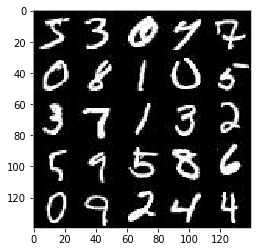

In [137]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

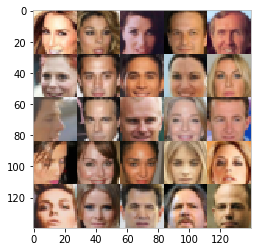

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name='lr')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [85]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # We only use the discriminator during training
    is_train = True
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # start with 28 x 28 x dim
        y = tf.layers.conv2d(images, 64, kernel_size=5, strides=2, padding='same')
        y = tf.layers.batch_normalization(y, training=is_train)
        y = tf.nn.elu(y)
        
        # 14 x 14 x 64
        y = tf.layers.conv2d(y, 128, kernel_size=5, strides=2, padding='same')
        y = tf.layers.batch_normalization(y, training=is_train)
        y = tf.nn.elu(y)
        
        # 7 x 7 x 128
        y = tf.layers.conv2d(y, 256, kernel_size=5, strides=2, padding='same')
        y = tf.layers.batch_normalization(y, training=is_train)
        y = tf.nn.elu(y)
        
        # 4 x 4 x 256
        y = tf.reshape(y, (-1, 4*4*256))
        logits = tf.layers.dense(y, 1)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [125]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Reuse the network if not training
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # start with shape of z
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.elu(x)
        
        # 2 x 2 x 512
        x = tf.layers.conv2d_transpose(x, 256, kernel_size=5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.elu(x)
        
        # 4 x 4 x 256
        x = tf.layers.conv2d_transpose(x, 128, kernel_size=4, strides=1, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.elu(x)
        
        # 7 x 7 x 128
        x = tf.layers.conv2d_transpose(x, 64, kernel_size=5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.nn.elu(x)
        
        # 14 x 14 x 64
        x = tf.layers.conv2d_transpose(x, out_channel_dim, kernel_size=5, strides=2, padding='same')
        x = tf.tanh(x) * 0.5  # scale to [-0.5,0.5] to match the dataset
        
        # 28 x 28 x out_channel_dim
    
    return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [127]:
def model_loss(input_real, input_z, out_channel_dim, label_smoothing_factor=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :param label_smoothing_factor: The smoothing factor to be multiplied to real input labels
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    d_real, d_real_logits = discriminator(input_real, reuse=False)
    d_fake, d_fake_logits = discriminator(g, reuse=True)
    
    # We want the discriminator to classify real inputs as real (1)
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_real_logits)*label_smoothing_factor, logits=d_real_logits))
    
    # We want the discriminator to classify fake inputs as fake (0)
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.zeros_like(d_fake_logits), logits=d_fake_logits))
    
    # We want the generator to produce inputs that the discriminator classify as real (1)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        labels=tf.ones_like(d_fake_logits), logits=d_fake_logits))
    
    d_loss = d_real_loss + d_fake_loss
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    global_step = tf.train.get_global_step()
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(
            d_loss, var_list=d_vars, global_step=global_step)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(
            g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [128]:
checkpoint_path = 'checkpoints'

def checkpoint(saver, sess, problem_name='mnist', step=None):
    """
    Creates a checkpoint during training in case I accidentally fall asleep and 
    either the generator or the discriminator dominates the other later on, ruining everything.
    :param saver: a tf.train.Saver object for saving the current state
    :param sess: the current session
    :param problem_name: The problem on which our network is training
    :param step: The current step number to be attached to the checkpoint file
    """
    saver.save(sess, os.path.join('checkpoints', '{}.ckpt'.format(problem_name)), global_step=step)

In [38]:
%matplotlib notebook

def plot_losses(d_losses, g_losses):
    fig, ax = pyplot.subplots()
    pyplot.plot(d_losses, label='Discriminator', alpha=0.5)
    pyplot.plot(g_losses, label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()

In [139]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, problem_name='mnist'):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    global_step = tf.train.get_or_create_global_step()
    
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    
    out_channel_dim = data_shape[-1]
    inputs_real, inputs_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver(max_to_keep=10, keep_checkpoint_every_n_hours=1)
    d_losses, g_losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_i, batch_images in enumerate(get_batches(batch_size)):
                
                z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                step, _ = sess.run([global_step, d_train_opt], feed_dict={
                    inputs_real: batch_images, inputs_z: z, lr: learning_rate })
                
                step, _ = sess.run([global_step, g_train_opt], feed_dict={
                    inputs_real: batch_images, inputs_z: z, lr: learning_rate*3 })  # hack to favor the generator a bit
                
                if step % (1000//batch_size) == 0:
                    d_loss_value = sess.run(d_loss, feed_dict={inputs_real: batch_images, inputs_z: z})
                    g_loss_value = sess.run(g_loss, feed_dict={inputs_z: z})
                    print('Epoch {} / Batch {} : d_loss = {:.4f}, g_loss = {:.4f}'.format(
                        epoch_i+1, batch_i+1, d_loss_value, g_loss_value))
                    d_losses.append(d_loss_value)
                    g_losses.append(g_loss_value)
                
                if step % (10000//batch_size) == 0:
                    checkpoint(saver, sess, problem_name, step)
                    show_generator_output(sess, 25, inputs_z, out_channel_dim, data_image_mode)
                
        checkpoint(saver, sess, problem_name, step)
        show_generator_output(sess, 100, inputs_z, out_channel_dim, data_image_mode)
        
    return d_losses, g_losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 / Batch 31 : d_loss = 1.3156, g_loss = 0.6538
Epoch 1 / Batch 62 : d_loss = 0.6001, g_loss = 1.6255
Epoch 1 / Batch 93 : d_loss = 0.4675, g_loss = 2.3058
Epoch 1 / Batch 124 : d_loss = 0.8737, g_loss = 1.4390
Epoch 1 / Batch 155 : d_loss = 1.3413, g_loss = 0.8735
Epoch 1 / Batch 186 : d_loss = 1.6432, g_loss = 0.3887
Epoch 1 / Batch 217 : d_loss = 1.1477, g_loss = 1.0925
Epoch 1 / Batch 248 : d_loss = 1.0011, g_loss = 1.2368
Epoch 1 / Batch 279 : d_loss = 1.2354, g_loss = 0.8777
Epoch 1 / Batch 310 : d_loss = 0.8589, g_loss = 1.6529


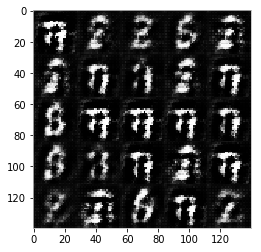

Epoch 1 / Batch 341 : d_loss = 1.2443, g_loss = 1.1428
Epoch 1 / Batch 372 : d_loss = 1.2678, g_loss = 0.9910
Epoch 1 / Batch 403 : d_loss = 0.8577, g_loss = 1.4075
Epoch 1 / Batch 434 : d_loss = 1.1211, g_loss = 1.0029
Epoch 1 / Batch 465 : d_loss = 1.2185, g_loss = 1.1160
Epoch 1 / Batch 496 : d_loss = 1.3459, g_loss = 0.8190
Epoch 1 / Batch 527 : d_loss = 1.1719, g_loss = 0.7232
Epoch 1 / Batch 558 : d_loss = 0.9335, g_loss = 1.8363
Epoch 1 / Batch 589 : d_loss = 1.3729, g_loss = 0.5923
Epoch 1 / Batch 620 : d_loss = 1.3025, g_loss = 0.9464


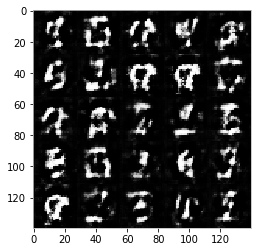

Epoch 1 / Batch 651 : d_loss = 1.1205, g_loss = 1.3755
Epoch 1 / Batch 682 : d_loss = 1.2949, g_loss = 1.0986
Epoch 1 / Batch 713 : d_loss = 1.3109, g_loss = 0.6707
Epoch 1 / Batch 744 : d_loss = 1.1586, g_loss = 0.8697
Epoch 1 / Batch 775 : d_loss = 1.2981, g_loss = 0.6863
Epoch 1 / Batch 806 : d_loss = 1.2247, g_loss = 0.6866
Epoch 1 / Batch 837 : d_loss = 1.1085, g_loss = 1.3134
Epoch 1 / Batch 868 : d_loss = 1.2633, g_loss = 0.5981
Epoch 1 / Batch 899 : d_loss = 0.9567, g_loss = 1.0429
Epoch 1 / Batch 930 : d_loss = 1.1562, g_loss = 0.9718


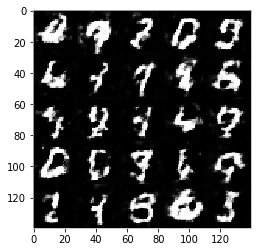

Epoch 1 / Batch 961 : d_loss = 0.8678, g_loss = 1.3993
Epoch 1 / Batch 992 : d_loss = 1.2144, g_loss = 0.6910
Epoch 1 / Batch 1023 : d_loss = 1.3158, g_loss = 0.8885
Epoch 1 / Batch 1054 : d_loss = 1.2204, g_loss = 1.0240
Epoch 1 / Batch 1085 : d_loss = 1.2554, g_loss = 0.8997
Epoch 1 / Batch 1116 : d_loss = 1.1292, g_loss = 0.9277
Epoch 1 / Batch 1147 : d_loss = 1.2515, g_loss = 0.7505
Epoch 1 / Batch 1178 : d_loss = 1.1425, g_loss = 0.7813
Epoch 1 / Batch 1209 : d_loss = 1.1938, g_loss = 1.2363
Epoch 1 / Batch 1240 : d_loss = 1.3218, g_loss = 0.6413


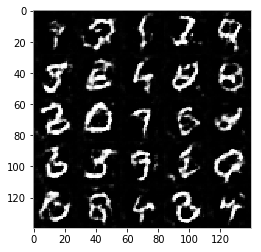

Epoch 1 / Batch 1271 : d_loss = 0.9975, g_loss = 1.2682
Epoch 1 / Batch 1302 : d_loss = 1.1771, g_loss = 0.8600
Epoch 1 / Batch 1333 : d_loss = 1.1925, g_loss = 1.1219
Epoch 1 / Batch 1364 : d_loss = 1.3252, g_loss = 0.6831
Epoch 1 / Batch 1395 : d_loss = 1.1259, g_loss = 0.9598
Epoch 1 / Batch 1426 : d_loss = 1.4016, g_loss = 0.9095
Epoch 1 / Batch 1457 : d_loss = 1.2479, g_loss = 0.7403
Epoch 1 / Batch 1488 : d_loss = 1.2167, g_loss = 0.8518
Epoch 1 / Batch 1519 : d_loss = 0.9644, g_loss = 1.0555
Epoch 1 / Batch 1550 : d_loss = 1.1248, g_loss = 1.2039


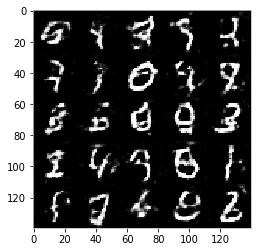

Epoch 1 / Batch 1581 : d_loss = 1.3600, g_loss = 0.5725
Epoch 1 / Batch 1612 : d_loss = 1.1737, g_loss = 0.7655
Epoch 1 / Batch 1643 : d_loss = 1.2700, g_loss = 0.6334
Epoch 1 / Batch 1674 : d_loss = 0.9879, g_loss = 1.1742
Epoch 1 / Batch 1705 : d_loss = 1.0642, g_loss = 1.4941
Epoch 1 / Batch 1736 : d_loss = 1.1476, g_loss = 1.1210
Epoch 1 / Batch 1767 : d_loss = 1.5656, g_loss = 0.5493
Epoch 1 / Batch 1798 : d_loss = 1.0397, g_loss = 0.8973
Epoch 1 / Batch 1829 : d_loss = 1.1700, g_loss = 0.8437
Epoch 1 / Batch 1860 : d_loss = 1.4292, g_loss = 0.5594


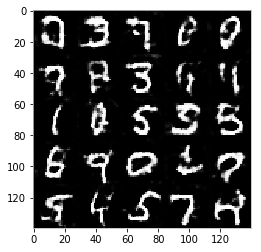

Epoch 2 / Batch 16 : d_loss = 1.0550, g_loss = 0.9176
Epoch 2 / Batch 47 : d_loss = 1.0679, g_loss = 0.9564
Epoch 2 / Batch 78 : d_loss = 1.1398, g_loss = 1.1983
Epoch 2 / Batch 109 : d_loss = 1.1062, g_loss = 0.8740
Epoch 2 / Batch 140 : d_loss = 1.0449, g_loss = 1.0651
Epoch 2 / Batch 171 : d_loss = 1.1505, g_loss = 1.5618
Epoch 2 / Batch 202 : d_loss = 1.0865, g_loss = 1.7022
Epoch 2 / Batch 233 : d_loss = 0.9989, g_loss = 0.9429
Epoch 2 / Batch 264 : d_loss = 1.1910, g_loss = 0.8564
Epoch 2 / Batch 295 : d_loss = 1.0807, g_loss = 0.7920


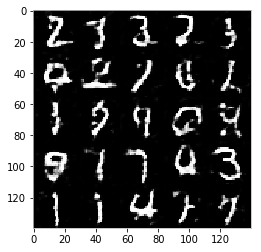

Epoch 2 / Batch 326 : d_loss = 1.0495, g_loss = 0.9852
Epoch 2 / Batch 357 : d_loss = 1.2308, g_loss = 0.7429
Epoch 2 / Batch 388 : d_loss = 1.0576, g_loss = 1.9154
Epoch 2 / Batch 419 : d_loss = 0.8185, g_loss = 1.8471
Epoch 2 / Batch 450 : d_loss = 1.1093, g_loss = 0.7870
Epoch 2 / Batch 481 : d_loss = 1.0395, g_loss = 1.2305
Epoch 2 / Batch 512 : d_loss = 1.3329, g_loss = 0.8096
Epoch 2 / Batch 543 : d_loss = 1.0528, g_loss = 1.0711
Epoch 2 / Batch 574 : d_loss = 1.2255, g_loss = 0.7735
Epoch 2 / Batch 605 : d_loss = 0.9344, g_loss = 0.9207


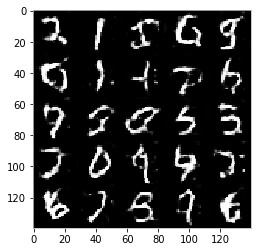

Epoch 2 / Batch 636 : d_loss = 1.1989, g_loss = 0.7668
Epoch 2 / Batch 667 : d_loss = 1.2504, g_loss = 0.6243
Epoch 2 / Batch 698 : d_loss = 1.1030, g_loss = 2.4234
Epoch 2 / Batch 729 : d_loss = 1.0722, g_loss = 0.9039
Epoch 2 / Batch 760 : d_loss = 0.8431, g_loss = 1.7486
Epoch 2 / Batch 791 : d_loss = 0.8326, g_loss = 1.2916
Epoch 2 / Batch 822 : d_loss = 0.9219, g_loss = 1.6087
Epoch 2 / Batch 853 : d_loss = 1.6335, g_loss = 0.4726
Epoch 2 / Batch 884 : d_loss = 0.7749, g_loss = 1.6081
Epoch 2 / Batch 915 : d_loss = 1.1558, g_loss = 0.8150


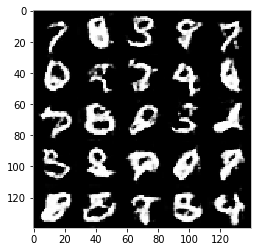

Epoch 2 / Batch 946 : d_loss = 1.1341, g_loss = 1.1850
Epoch 2 / Batch 977 : d_loss = 1.4603, g_loss = 0.4882
Epoch 2 / Batch 1008 : d_loss = 0.8992, g_loss = 1.5684
Epoch 2 / Batch 1039 : d_loss = 0.9800, g_loss = 1.0064
Epoch 2 / Batch 1070 : d_loss = 1.0691, g_loss = 0.8011
Epoch 2 / Batch 1101 : d_loss = 1.1550, g_loss = 0.7961
Epoch 2 / Batch 1132 : d_loss = 1.4188, g_loss = 0.4914
Epoch 2 / Batch 1163 : d_loss = 0.8397, g_loss = 1.2569
Epoch 2 / Batch 1194 : d_loss = 0.8130, g_loss = 1.2553
Epoch 2 / Batch 1225 : d_loss = 1.4518, g_loss = 0.4865


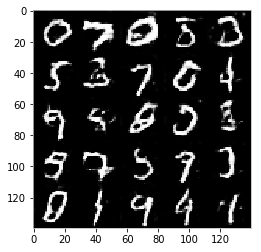

Epoch 2 / Batch 1256 : d_loss = 0.9504, g_loss = 1.2438
Epoch 2 / Batch 1287 : d_loss = 1.0435, g_loss = 0.9176
Epoch 2 / Batch 1318 : d_loss = 1.1493, g_loss = 0.8247
Epoch 2 / Batch 1349 : d_loss = 1.0276, g_loss = 1.0287
Epoch 2 / Batch 1380 : d_loss = 0.8228, g_loss = 1.3715
Epoch 2 / Batch 1411 : d_loss = 0.8491, g_loss = 1.5590
Epoch 2 / Batch 1442 : d_loss = 1.0878, g_loss = 0.7981
Epoch 2 / Batch 1473 : d_loss = 0.8780, g_loss = 1.6249
Epoch 2 / Batch 1504 : d_loss = 1.0572, g_loss = 0.8182
Epoch 2 / Batch 1535 : d_loss = 1.1526, g_loss = 0.8009


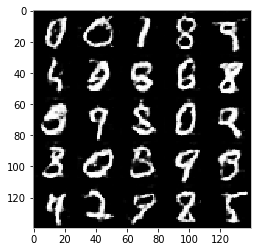

Epoch 2 / Batch 1566 : d_loss = 1.1096, g_loss = 1.0521
Epoch 2 / Batch 1597 : d_loss = 0.9076, g_loss = 1.1853
Epoch 2 / Batch 1628 : d_loss = 1.0173, g_loss = 0.8195
Epoch 2 / Batch 1659 : d_loss = 1.0361, g_loss = 0.8261
Epoch 2 / Batch 1690 : d_loss = 0.9326, g_loss = 1.0757
Epoch 2 / Batch 1721 : d_loss = 0.5148, g_loss = 2.9952
Epoch 2 / Batch 1752 : d_loss = 0.9976, g_loss = 1.0633
Epoch 2 / Batch 1783 : d_loss = 0.9091, g_loss = 1.5074
Epoch 2 / Batch 1814 : d_loss = 1.0947, g_loss = 1.0546
Epoch 2 / Batch 1845 : d_loss = 0.8874, g_loss = 1.1516


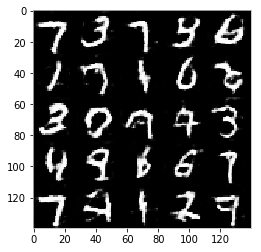

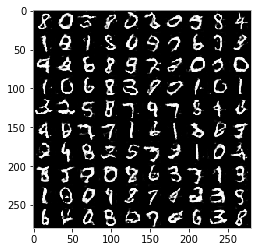

In [140]:
batch_size = 32
z_dim = 256
learning_rate = 1e-4
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 'mnist')

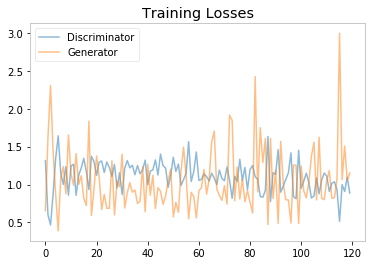

In [141]:
plot_losses(d_losses, g_losses)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 / Batch 31 : d_loss = 2.4108, g_loss = 0.2265
Epoch 1 / Batch 62 : d_loss = 0.9364, g_loss = 1.2439
Epoch 1 / Batch 93 : d_loss = 0.8408, g_loss = 1.4654
Epoch 1 / Batch 124 : d_loss = 0.5917, g_loss = 1.8718
Epoch 1 / Batch 155 : d_loss = 0.6738, g_loss = 1.5594
Epoch 1 / Batch 186 : d_loss = 0.9227, g_loss = 3.4523
Epoch 1 / Batch 217 : d_loss = 0.9444, g_loss = 1.3256
Epoch 1 / Batch 248 : d_loss = 0.6956, g_loss = 2.0447
Epoch 1 / Batch 279 : d_loss = 0.8980, g_loss = 1.7050
Epoch 1 / Batch 310 : d_loss = 0.8292, g_loss = 1.7094


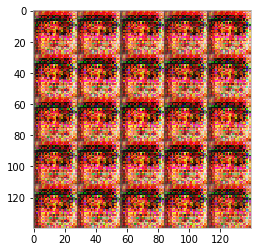

Epoch 1 / Batch 341 : d_loss = 0.5310, g_loss = 2.2907
Epoch 1 / Batch 372 : d_loss = 0.4317, g_loss = 2.6988
Epoch 1 / Batch 403 : d_loss = 0.5754, g_loss = 2.2852
Epoch 1 / Batch 434 : d_loss = 0.8314, g_loss = 1.7582
Epoch 1 / Batch 465 : d_loss = 0.6450, g_loss = 2.0991
Epoch 1 / Batch 496 : d_loss = 1.0339, g_loss = 0.9062
Epoch 1 / Batch 527 : d_loss = 1.7639, g_loss = 0.6591
Epoch 1 / Batch 558 : d_loss = 1.4027, g_loss = 0.7579
Epoch 1 / Batch 589 : d_loss = 1.2871, g_loss = 0.9264
Epoch 1 / Batch 620 : d_loss = 1.5678, g_loss = 0.5533


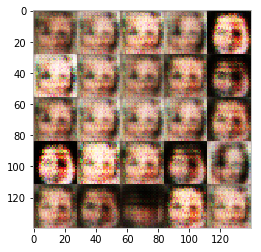

Epoch 1 / Batch 651 : d_loss = 1.4077, g_loss = 0.8677
Epoch 1 / Batch 682 : d_loss = 1.2374, g_loss = 1.7273
Epoch 1 / Batch 713 : d_loss = 1.1917, g_loss = 0.7350
Epoch 1 / Batch 744 : d_loss = 1.1747, g_loss = 0.7625
Epoch 1 / Batch 775 : d_loss = 1.0177, g_loss = 2.1849
Epoch 1 / Batch 806 : d_loss = 0.8684, g_loss = 1.0598
Epoch 1 / Batch 837 : d_loss = 0.5181, g_loss = 3.1325
Epoch 1 / Batch 868 : d_loss = 0.8498, g_loss = 2.3698
Epoch 1 / Batch 899 : d_loss = 1.0928, g_loss = 3.1803
Epoch 1 / Batch 930 : d_loss = 1.4077, g_loss = 0.5232


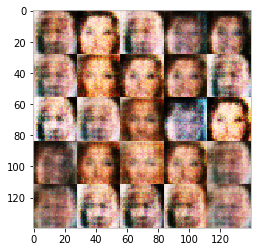

Epoch 1 / Batch 961 : d_loss = 1.0606, g_loss = 1.7047
Epoch 1 / Batch 992 : d_loss = 0.8760, g_loss = 1.0726
Epoch 1 / Batch 1023 : d_loss = 1.9466, g_loss = 0.3043
Epoch 1 / Batch 1054 : d_loss = 1.1237, g_loss = 0.8492
Epoch 1 / Batch 1085 : d_loss = 1.5022, g_loss = 0.5970
Epoch 1 / Batch 1116 : d_loss = 1.5100, g_loss = 0.5432
Epoch 1 / Batch 1147 : d_loss = 1.6213, g_loss = 0.4357
Epoch 1 / Batch 1178 : d_loss = 1.2809, g_loss = 0.9853
Epoch 1 / Batch 1209 : d_loss = 1.3307, g_loss = 0.8051
Epoch 1 / Batch 1240 : d_loss = 1.4634, g_loss = 0.5150


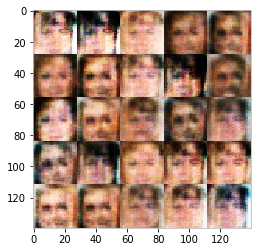

Epoch 1 / Batch 1271 : d_loss = 1.6150, g_loss = 0.4332
Epoch 1 / Batch 1302 : d_loss = 1.1024, g_loss = 0.8549
Epoch 1 / Batch 1333 : d_loss = 1.3535, g_loss = 0.8738
Epoch 1 / Batch 1364 : d_loss = 1.2131, g_loss = 0.7591
Epoch 1 / Batch 1395 : d_loss = 0.8605, g_loss = 1.4465
Epoch 1 / Batch 1426 : d_loss = 1.0828, g_loss = 0.8179
Epoch 1 / Batch 1457 : d_loss = 0.7683, g_loss = 2.1588
Epoch 1 / Batch 1488 : d_loss = 1.1668, g_loss = 0.9053
Epoch 1 / Batch 1519 : d_loss = 1.6015, g_loss = 1.5327
Epoch 1 / Batch 1550 : d_loss = 1.2112, g_loss = 1.1792


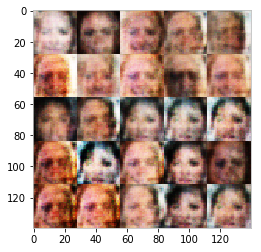

Epoch 1 / Batch 1581 : d_loss = 1.2413, g_loss = 1.1454
Epoch 1 / Batch 1612 : d_loss = 1.4917, g_loss = 0.4947
Epoch 1 / Batch 1643 : d_loss = 1.1021, g_loss = 1.6894
Epoch 1 / Batch 1674 : d_loss = 1.3768, g_loss = 0.7708
Epoch 1 / Batch 1705 : d_loss = 1.3076, g_loss = 0.8653
Epoch 1 / Batch 1736 : d_loss = 1.0954, g_loss = 1.1575
Epoch 1 / Batch 1767 : d_loss = 1.3413, g_loss = 0.6938
Epoch 1 / Batch 1798 : d_loss = 1.4851, g_loss = 0.6250
Epoch 1 / Batch 1829 : d_loss = 0.9961, g_loss = 1.2600
Epoch 1 / Batch 1860 : d_loss = 1.2229, g_loss = 0.8567


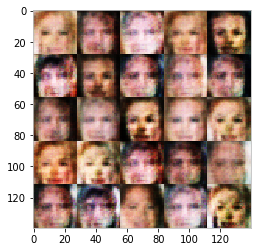

Epoch 1 / Batch 1891 : d_loss = 0.6721, g_loss = 1.6987
Epoch 1 / Batch 1922 : d_loss = 1.1930, g_loss = 1.5095
Epoch 1 / Batch 1953 : d_loss = 0.9699, g_loss = 1.3656
Epoch 1 / Batch 1984 : d_loss = 1.1973, g_loss = 1.0200
Epoch 1 / Batch 2015 : d_loss = 1.0897, g_loss = 0.8686
Epoch 1 / Batch 2046 : d_loss = 1.0368, g_loss = 1.4974
Epoch 1 / Batch 2077 : d_loss = 0.8560, g_loss = 1.1143
Epoch 1 / Batch 2108 : d_loss = 1.3356, g_loss = 1.2162
Epoch 1 / Batch 2139 : d_loss = 0.9468, g_loss = 1.9540
Epoch 1 / Batch 2170 : d_loss = 1.4046, g_loss = 1.1319


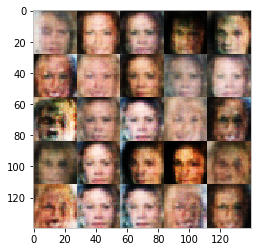

Epoch 1 / Batch 2201 : d_loss = 0.9298, g_loss = 1.3261
Epoch 1 / Batch 2232 : d_loss = 1.2228, g_loss = 0.6396
Epoch 1 / Batch 2263 : d_loss = 1.0169, g_loss = 1.2667
Epoch 1 / Batch 2294 : d_loss = 1.0456, g_loss = 0.8665
Epoch 1 / Batch 2325 : d_loss = 0.8682, g_loss = 1.6356
Epoch 1 / Batch 2356 : d_loss = 0.9829, g_loss = 0.9606
Epoch 1 / Batch 2387 : d_loss = 1.3123, g_loss = 1.0723
Epoch 1 / Batch 2418 : d_loss = 1.2981, g_loss = 0.7714
Epoch 1 / Batch 2449 : d_loss = 0.7943, g_loss = 1.6108
Epoch 1 / Batch 2480 : d_loss = 1.1926, g_loss = 1.1732


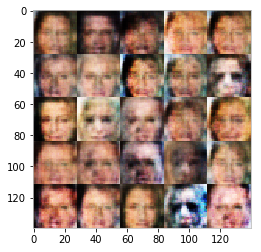

Epoch 1 / Batch 2511 : d_loss = 1.2578, g_loss = 0.8967
Epoch 1 / Batch 2542 : d_loss = 1.2935, g_loss = 0.7013
Epoch 1 / Batch 2573 : d_loss = 1.1274, g_loss = 0.7875
Epoch 1 / Batch 2604 : d_loss = 0.9596, g_loss = 1.0742
Epoch 1 / Batch 2635 : d_loss = 1.0782, g_loss = 1.0805
Epoch 1 / Batch 2666 : d_loss = 0.9471, g_loss = 1.2761
Epoch 1 / Batch 2697 : d_loss = 0.8933, g_loss = 1.5795
Epoch 1 / Batch 2728 : d_loss = 1.0405, g_loss = 0.9027
Epoch 1 / Batch 2759 : d_loss = 1.1251, g_loss = 0.8306
Epoch 1 / Batch 2790 : d_loss = 1.1056, g_loss = 1.0869


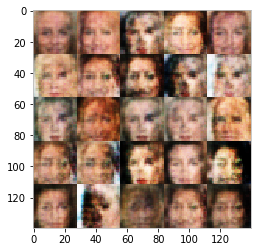

Epoch 1 / Batch 2821 : d_loss = 1.1105, g_loss = 0.7314
Epoch 1 / Batch 2852 : d_loss = 1.0445, g_loss = 1.7285
Epoch 1 / Batch 2883 : d_loss = 1.0552, g_loss = 0.8841
Epoch 1 / Batch 2914 : d_loss = 1.1987, g_loss = 1.2103
Epoch 1 / Batch 2945 : d_loss = 1.7898, g_loss = 1.0455
Epoch 1 / Batch 2976 : d_loss = 1.1215, g_loss = 1.1246
Epoch 1 / Batch 3007 : d_loss = 0.9847, g_loss = 1.2293
Epoch 1 / Batch 3038 : d_loss = 0.9656, g_loss = 1.1703
Epoch 1 / Batch 3069 : d_loss = 1.1169, g_loss = 0.9092
Epoch 1 / Batch 3100 : d_loss = 1.2267, g_loss = 0.7526


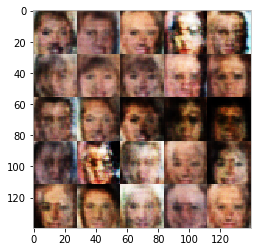

Epoch 1 / Batch 3131 : d_loss = 1.1606, g_loss = 0.8948
Epoch 1 / Batch 3162 : d_loss = 1.0525, g_loss = 1.0979
Epoch 1 / Batch 3193 : d_loss = 0.9964, g_loss = 1.1913
Epoch 1 / Batch 3224 : d_loss = 1.1223, g_loss = 1.4890
Epoch 1 / Batch 3255 : d_loss = 1.0783, g_loss = 0.9759
Epoch 1 / Batch 3286 : d_loss = 1.0777, g_loss = 0.9120
Epoch 1 / Batch 3317 : d_loss = 1.1198, g_loss = 0.9088
Epoch 1 / Batch 3348 : d_loss = 1.0155, g_loss = 1.1351
Epoch 1 / Batch 3379 : d_loss = 1.6627, g_loss = 1.5053
Epoch 1 / Batch 3410 : d_loss = 0.9262, g_loss = 1.2959


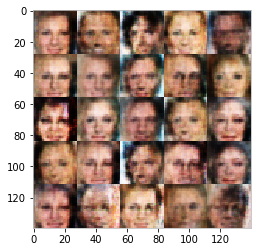

Epoch 1 / Batch 3441 : d_loss = 1.0747, g_loss = 1.2772
Epoch 1 / Batch 3472 : d_loss = 0.9962, g_loss = 1.3910
Epoch 1 / Batch 3503 : d_loss = 1.2294, g_loss = 0.6509
Epoch 1 / Batch 3534 : d_loss = 0.9765, g_loss = 1.2234
Epoch 1 / Batch 3565 : d_loss = 1.0048, g_loss = 1.0347
Epoch 1 / Batch 3596 : d_loss = 1.0030, g_loss = 1.2268
Epoch 1 / Batch 3627 : d_loss = 1.0329, g_loss = 1.5090
Epoch 1 / Batch 3658 : d_loss = 1.1798, g_loss = 0.7918
Epoch 1 / Batch 3689 : d_loss = 1.1085, g_loss = 1.0725
Epoch 1 / Batch 3720 : d_loss = 1.1356, g_loss = 1.3521


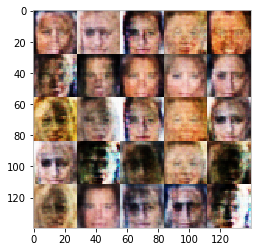

Epoch 1 / Batch 3751 : d_loss = 0.9641, g_loss = 1.1186
Epoch 1 / Batch 3782 : d_loss = 0.8670, g_loss = 1.3872
Epoch 1 / Batch 3813 : d_loss = 1.2915, g_loss = 1.3433
Epoch 1 / Batch 3844 : d_loss = 1.5456, g_loss = 0.4937
Epoch 1 / Batch 3875 : d_loss = 1.1796, g_loss = 1.1478
Epoch 1 / Batch 3906 : d_loss = 0.7468, g_loss = 1.8743
Epoch 1 / Batch 3937 : d_loss = 0.9829, g_loss = 1.1076
Epoch 1 / Batch 3968 : d_loss = 1.0237, g_loss = 0.9192
Epoch 1 / Batch 3999 : d_loss = 1.0928, g_loss = 0.8745
Epoch 1 / Batch 4030 : d_loss = 1.0963, g_loss = 1.0727


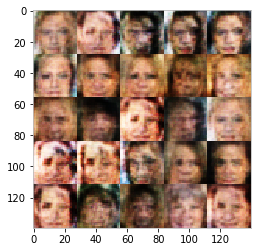

Epoch 1 / Batch 4061 : d_loss = 1.3130, g_loss = 0.7138
Epoch 1 / Batch 4092 : d_loss = 1.0536, g_loss = 0.8125
Epoch 1 / Batch 4123 : d_loss = 1.0174, g_loss = 1.0563
Epoch 1 / Batch 4154 : d_loss = 1.0659, g_loss = 1.1737
Epoch 1 / Batch 4185 : d_loss = 0.8839, g_loss = 1.4764
Epoch 1 / Batch 4216 : d_loss = 0.8739, g_loss = 1.3524
Epoch 1 / Batch 4247 : d_loss = 1.0687, g_loss = 1.7688
Epoch 1 / Batch 4278 : d_loss = 1.0388, g_loss = 1.2206
Epoch 1 / Batch 4309 : d_loss = 0.7185, g_loss = 1.7683
Epoch 1 / Batch 4340 : d_loss = 1.2494, g_loss = 0.6435


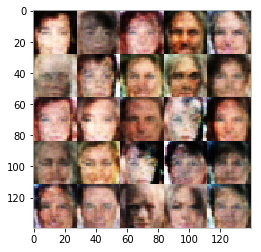

Epoch 1 / Batch 4371 : d_loss = 1.1140, g_loss = 1.0943
Epoch 1 / Batch 4402 : d_loss = 1.0668, g_loss = 1.0119
Epoch 1 / Batch 4433 : d_loss = 1.0280, g_loss = 1.1068
Epoch 1 / Batch 4464 : d_loss = 1.0414, g_loss = 1.0583
Epoch 1 / Batch 4495 : d_loss = 1.0841, g_loss = 1.0995
Epoch 1 / Batch 4526 : d_loss = 1.0442, g_loss = 1.0575
Epoch 1 / Batch 4557 : d_loss = 1.0654, g_loss = 0.8619
Epoch 1 / Batch 4588 : d_loss = 0.9982, g_loss = 1.4190
Epoch 1 / Batch 4619 : d_loss = 1.2020, g_loss = 0.7954
Epoch 1 / Batch 4650 : d_loss = 0.8524, g_loss = 1.3193


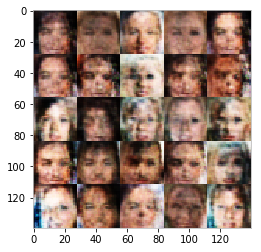

Epoch 1 / Batch 4681 : d_loss = 1.0548, g_loss = 1.3533
Epoch 1 / Batch 4712 : d_loss = 1.0422, g_loss = 0.8699
Epoch 1 / Batch 4743 : d_loss = 0.9538, g_loss = 1.1746
Epoch 1 / Batch 4774 : d_loss = 1.2190, g_loss = 0.7814
Epoch 1 / Batch 4805 : d_loss = 0.8557, g_loss = 1.2092
Epoch 1 / Batch 4836 : d_loss = 0.9543, g_loss = 1.2810
Epoch 1 / Batch 4867 : d_loss = 1.0440, g_loss = 1.3028
Epoch 1 / Batch 4898 : d_loss = 0.8639, g_loss = 1.6094
Epoch 1 / Batch 4929 : d_loss = 0.9124, g_loss = 1.1946
Epoch 1 / Batch 4960 : d_loss = 0.9384, g_loss = 1.4258
Epoch 1 / Batch 4991 : d_loss = 1.0930, g_loss = 1.2703


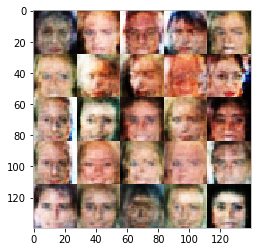

Epoch 1 / Batch 5022 : d_loss = 1.2835, g_loss = 0.5913
Epoch 1 / Batch 5053 : d_loss = 0.9612, g_loss = 1.1244
Epoch 1 / Batch 5084 : d_loss = 1.1696, g_loss = 1.6307
Epoch 1 / Batch 5115 : d_loss = 0.8450, g_loss = 1.2700
Epoch 1 / Batch 5146 : d_loss = 0.8159, g_loss = 1.5575
Epoch 1 / Batch 5177 : d_loss = 1.0670, g_loss = 0.8606
Epoch 1 / Batch 5208 : d_loss = 0.8792, g_loss = 1.2871
Epoch 1 / Batch 5239 : d_loss = 1.1072, g_loss = 0.9859
Epoch 1 / Batch 5270 : d_loss = 0.7832, g_loss = 1.9185
Epoch 1 / Batch 5301 : d_loss = 0.7751, g_loss = 1.5362


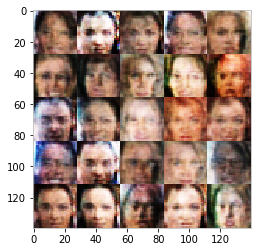

Epoch 1 / Batch 5332 : d_loss = 1.0571, g_loss = 0.8718
Epoch 1 / Batch 5363 : d_loss = 0.8104, g_loss = 1.5634
Epoch 1 / Batch 5394 : d_loss = 0.7723, g_loss = 1.2789
Epoch 1 / Batch 5425 : d_loss = 1.0242, g_loss = 1.0689
Epoch 1 / Batch 5456 : d_loss = 0.8709, g_loss = 1.3994
Epoch 1 / Batch 5487 : d_loss = 0.9287, g_loss = 1.1321
Epoch 1 / Batch 5518 : d_loss = 0.9553, g_loss = 1.1003
Epoch 1 / Batch 5549 : d_loss = 1.0781, g_loss = 0.8586
Epoch 1 / Batch 5580 : d_loss = 1.0474, g_loss = 1.0786
Epoch 1 / Batch 5611 : d_loss = 1.1669, g_loss = 0.9678


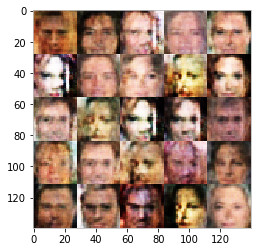

Epoch 1 / Batch 5642 : d_loss = 0.8968, g_loss = 1.2288
Epoch 1 / Batch 5673 : d_loss = 1.4568, g_loss = 0.4599
Epoch 1 / Batch 5704 : d_loss = 1.1140, g_loss = 1.2273
Epoch 1 / Batch 5735 : d_loss = 0.8438, g_loss = 1.3058
Epoch 1 / Batch 5766 : d_loss = 0.8784, g_loss = 1.4753
Epoch 1 / Batch 5797 : d_loss = 0.9150, g_loss = 1.2180
Epoch 1 / Batch 5828 : d_loss = 1.2108, g_loss = 0.7223
Epoch 1 / Batch 5859 : d_loss = 1.0460, g_loss = 1.5817
Epoch 1 / Batch 5890 : d_loss = 1.2610, g_loss = 0.7721
Epoch 1 / Batch 5921 : d_loss = 1.1233, g_loss = 1.0538


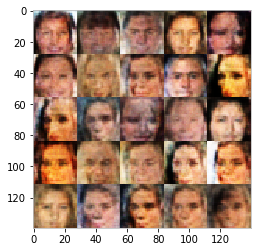

Epoch 1 / Batch 5952 : d_loss = 0.7543, g_loss = 1.2955
Epoch 1 / Batch 5983 : d_loss = 1.1034, g_loss = 0.9876
Epoch 1 / Batch 6014 : d_loss = 1.0913, g_loss = 0.9457
Epoch 1 / Batch 6045 : d_loss = 1.2734, g_loss = 0.8193
Epoch 1 / Batch 6076 : d_loss = 1.0163, g_loss = 0.9418
Epoch 1 / Batch 6107 : d_loss = 0.8456, g_loss = 1.3905
Epoch 1 / Batch 6138 : d_loss = 1.0513, g_loss = 1.0110
Epoch 1 / Batch 6169 : d_loss = 0.8825, g_loss = 1.4803
Epoch 1 / Batch 6200 : d_loss = 1.0626, g_loss = 0.9184
Epoch 1 / Batch 6231 : d_loss = 0.9199, g_loss = 1.2208


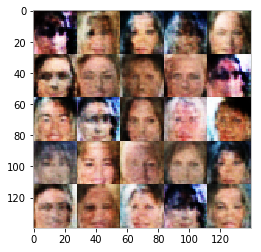

Epoch 1 / Batch 6262 : d_loss = 1.2059, g_loss = 0.7744
Epoch 1 / Batch 6293 : d_loss = 0.8404, g_loss = 1.5178
Epoch 1 / Batch 6324 : d_loss = 1.0047, g_loss = 1.1872


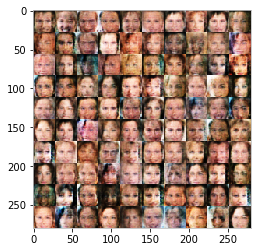

In [142]:
batch_size = 32
z_dim = 256
learning_rate = 1e-4
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    d_losses, g_losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, 'celeba')

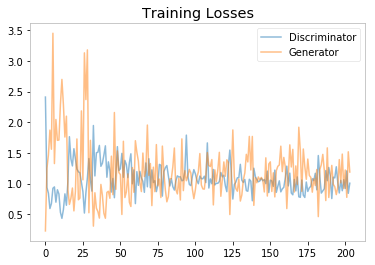

In [143]:
plot_losses(d_losses, g_losses)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.